In [210]:
import pytensor
pytensor.config.cxx = "/usr/bin/clang++"

In [211]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from matplotlib import cm
import arviz as az
import pymc as pm

In [212]:
data = pd.read_csv(Path("data") / "golf.txt", sep=r"\s+", skiprows=2)
data["x"] = data["x"] / 20.0
data["y"] = np.round(data["y"] / 1.0)
data["n"] = np.round(data["n"] / 1.0)
data["prop"] = data["y"] / data["n"]

In [213]:
data.head()

,x,n,y,prop
0,0.10,1443.0,1346.0,0.932779
1,0.15,694.0,577.0,0.831412
2,0.20,455.0,337.0,0.740659
3,0.25,353.0,208.0,0.589235
4,0.30,272.0,149.0,0.547794


In [214]:
x = np.array(data["x"])
n = np.array(data["n"])
y = np.array(data["y"])
prop = np.array(data["prop"])

Text(0, 0.5, 'putt proportion')

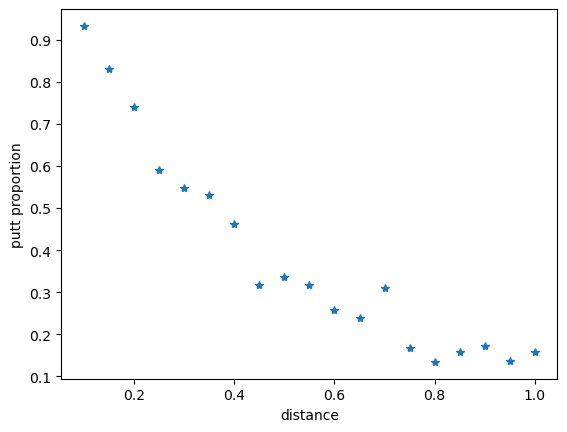

In [215]:
plt.figure()
plt.plot(x, prop, "*")
plt.xlabel("distance")
plt.ylabel("putt proportion")

In [216]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

## Modeling assumptions

For the probabilistic model, we make the following assumptions:

1. The outcome of the $n_i$ puts at each distance $i$ are *independent*. Each animal in the group has probability $p_i$ of death.

2. The probability of death $p_i$ depends on the dose $x_i$ as follows:
    $$p_i =  \rm{sigm}(1 + \alpha x + \beta x^2)$$ 
    where 
    $$
    \rm{sigm}(z) = \frac{1}{1 + e^{-z}}.
    $$
3. The prior probability of the parameters 
$\theta = \begin{bmatrix}
\alpha \\
\beta
\end{bmatrix}$
is Gaussian: 
\begin{align}
\alpha &\sim \mathcal{N}(\mu_\alpha, \sigma^2_\alpha), \qquad \mu_\alpha = 0, \sigma_\alpha=2\\
\beta &\sim \mathcal{N}(\mu_\beta, \sigma^2_\beta), \qquad \mu_\beta=10, \sigma_\beta=10.
\end{align}
4. The outcomes in the four groups are independent of each other, given $\theta$.

## 1.1: Probabilistic model

* Derive and comment the full probabilistic model.

Putting together the probabilistic assumptions 1-3, we obtain:

\begin{align*}
y_i | p_i &\sim  \mathrm{Binomial}(n_i, \rm{sigm}(\alpha + \beta x_i))\\
%p_i &= \rm{sigm}(\alpha + \beta x_i) \\
\alpha &\sim \mathcal{N}(0, 4)\\
\beta &\sim \mathcal{N}(10, 100).
\end{align*}

Furthermore, according to assumption 4:

$$P(y|\theta) = \prod_i P(y_i|\theta)$$

## 1.2: Maximum Likelihood estimation 

* Derive an analytical expression of the likelihood function $\mathcal{L}(\theta) = P(y|\theta)$.

The likelihood function $\mathcal{L}(\theta)$ is $P(y|\theta)$, seen as a function of $\theta$, with $y$ fixed to the observed outcome. <br/>Since the individual observations $y_i$ are independent, we have:

$$\mathcal{L}(\theta) = P(y|\theta) = \prod_{i=1}^N {{n_i}\choose{y_i}} \mathrm{sigm}(\alpha + \beta x_i)^{y_i} \cdot (1- \mathrm{sigm}(\alpha + \beta x_i))^{n_i - y_i}$$

* Derive an analytical expression of the log-likelihood function $\ell(\theta)$. 

$$\ell(\theta) = \log \mathcal{L}(\theta) = \sum_i {{n_i}\choose{y_i}} + \sum_i y_i \log \mathrm{sigm}(\alpha + \beta x_i) +  (n_i - y_i) \log (1- \mathrm{sigm}(\alpha + \beta x_i)).$$

The constant term $\sum_i {{n_i}\choose{y_i}}$ may be ignored.

* Write a Python function corresponding to the log-likelihood function $\ell(\theta)$ (possibly up to an additive factor).

In [217]:
def log_lik(alpha, beta):
    alpha = np.atleast_1d(alpha)[..., np.newaxis]  # useful to handle grid data
    beta = np.atleast_1d(beta)[..., np.newaxis]  # useful to handle grid data
    p = sigmoid(alpha * x + beta)
    # log_lik = y*np.log(gamma) + (n-y)*np.log(1-gamma)
    # nan_to_num handles the multiplication 0*np.inf and set it to 0, as required in our case...
    log_lik = np.nan_to_num(y * np.log(p), nan=0) + np.nan_to_num(
        (n - y) * np.log(1 - p), nan=0
    )
    return np.sum(log_lik, axis=-1)

* Visualize the log-likelihood and the likelihood function in 2D and comment the obtained figure. 

Text(0, 0.5, '$\\beta$')

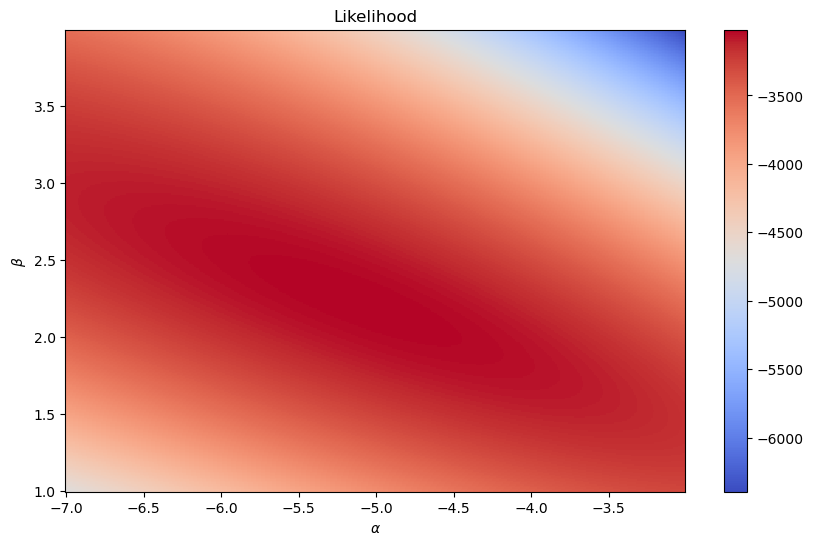

In [218]:
dalpha = 0.01
dbeta = 0.01
ALPHA = np.arange(-7.0, -3.00, dalpha)
BETA = np.arange(1.0, 4.0, dbeta)
AA, BB = np.meshgrid(ALPHA, BETA, indexing="xy")
AABB = np.stack((AA, BB), axis=-1)

LOG_LIK = log_lik(AA, BB)
fig, ax = plt.subplots(figsize=(10, 6))
c = ax.pcolormesh(AA, BB, LOG_LIK, cmap=cm.coolwarm, shading="auto")
# plt.plot(theta_ml[0], theta_ml[1], "kx")
fig.colorbar(c, ax=ax)
ax.set_title(f"Likelihood")
ax.set_xlabel(r"$\alpha$")
ax.set_ylabel(r"$\beta$")

Text(0, 0.5, '$\\beta$')

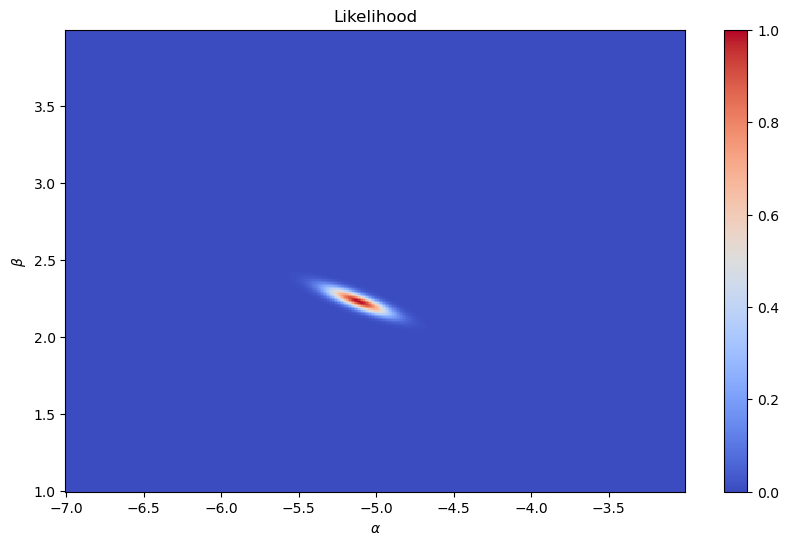

In [219]:
LIK_SAFE = np.exp(LOG_LIK - np.max(LOG_LIK))

fig, ax = plt.subplots(figsize=(10, 6))
c = ax.pcolormesh(AA, BB, LIK_SAFE, cmap=cm.coolwarm, shading="auto")
fig.colorbar(c, ax=ax)
ax.set_title(f"Likelihood")
ax.set_xlabel(r"$\alpha$")
ax.set_ylabel(r"$\beta$")

* Compute the maximum likelihood estimate $\alpha^{\rm ml}, \beta^{\rm ml}$ of the parameters $\alpha, \beta$ through numerical optimizations. 

    Hints:
     * You may use the Python function `scipy.optimize.minimize`. 
     * You may look at the figures above to define a good starting point for optimization 
     * You may either minimize the likelihood or the log-likelihood. What is your choice?

In [220]:
from scipy.optimize import minimize

log_lik_theta = lambda theta: log_lik(theta[0], theta[1])
nll_theta = lambda theta: -log_lik_theta(theta)  # negative log-likelihood function.
res = minimize(nll_theta, x0=[4, -8])
theta_ml = res.x

* Visualize the likelihood function in 2D together with the ML estimate. Comment the obtained figure. 

Text(0, 0.5, '$\\beta$')

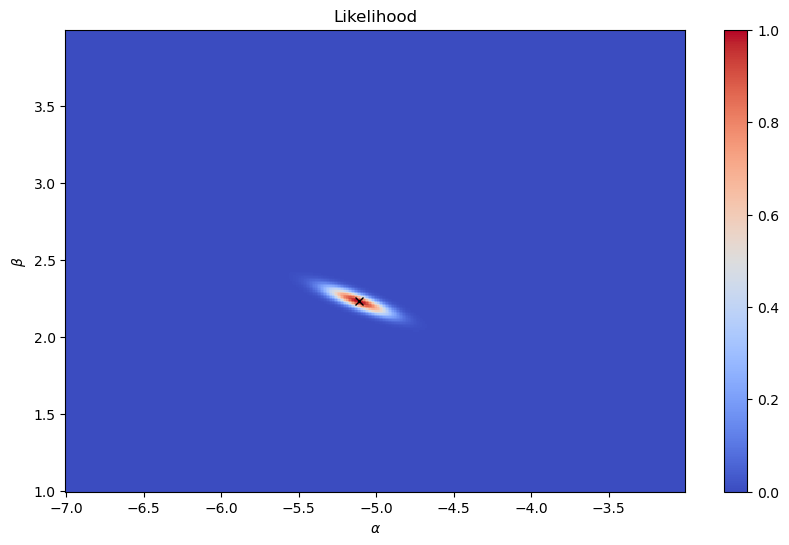

In [221]:
fig, ax = plt.subplots(figsize=(10, 6))
c = ax.pcolormesh(AA, BB, LIK_SAFE, cmap=cm.coolwarm, shading="auto")
plt.plot(theta_ml[0], theta_ml[1], "kx")
fig.colorbar(c, ax=ax)
ax.set_title(f"Likelihood")
ax.set_xlabel(r"$\alpha$")
ax.set_ylabel(r"$\beta$")

## 1.2: Maximum A Posteriori Estimation

* Derive an analytical expression of the posterior $f(\theta | y)$, up to a multiplicative factor not depending on $\theta$. 

Hint: exploit the already-obtained likelihood and the functional form of the Gaussian pdf.

$$f(\theta | y) = \frac{P(y | \theta) f(\theta)}{P(y)} \propto \mathcal{L}(\theta)
\exp\left(-\frac{1}{2} \frac{(\alpha - \mu_\alpha)^2}{\sigma^2_\alpha} \right ) 
\exp\left(-\frac{1}{2} \frac{(\beta - \mu_\beta)^2}{\sigma^2_\beta} \right ). $$ 

* Write the unnormalized posterior and log-posterior (up to a multiplicative/additive factor, respectively) as Python functions.

In [222]:
mu_alpha = 0
sigma_alpha = 1
mu_beta = 0
sigma_beta = 1

prior_alpha = stats.norm(loc=mu_alpha, scale=sigma_alpha)
prior_beta = stats.norm(loc=mu_beta, scale=sigma_beta)


def log_post_unscaled(alpha, beta):
    log_lik_val = log_lik(alpha, beta)
    # return lik_val * prior_alpha.pdf(alpha) * prior_beta.pdf(beta)
    return (
        log_lik_val
        - 0.5 * (alpha - mu_alpha) ** 2 / sigma_alpha**2
        - 0.5 * (beta - mu_beta) ** 2 / sigma_beta**2
    )

* Compute the maximum a posteriore estimate $\alpha^{\rm MAP}, \beta^{\rm MAP}$.

In [223]:
minus_logpost = lambda theta: -log_post_unscaled(theta[0], theta[1])
res = minimize(minus_logpost, x0=[-5, 2])
theta_map = res.x

Text(0, 0.5, '$\\beta$')

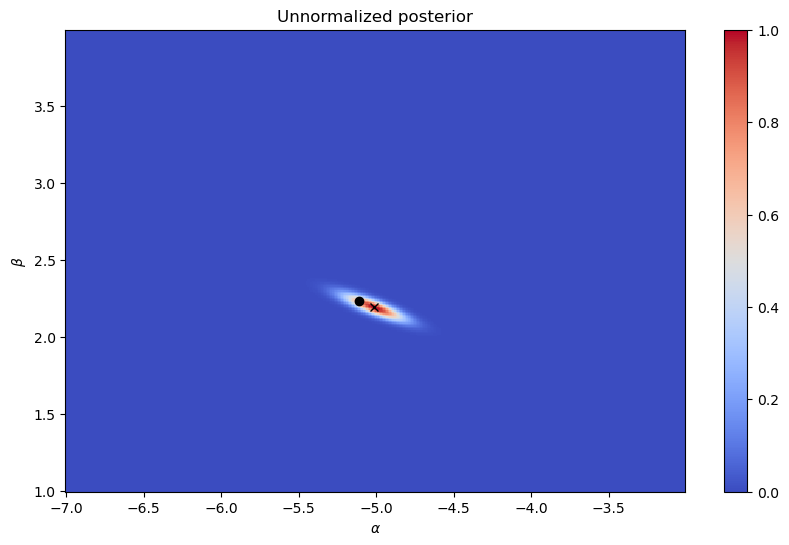

In [224]:
LOG_POST_UNSC = log_post_unscaled(AA, BB)
POST_UNSC = np.exp(LOG_POST_UNSC - np.max(LOG_POST_UNSC))

fig, ax = plt.subplots(figsize=(10, 6))
c = ax.pcolormesh(AA, BB, POST_UNSC, cmap=cm.coolwarm, shading="auto")
plt.plot(theta_map[0], theta_map[1], "kx")
plt.plot(theta_ml[0], theta_ml[1], "ko")
fig.colorbar(c, ax=ax)
ax.set_title(f"Unnormalized posterior")
ax.set_xlabel(r"$\alpha$")
ax.set_ylabel(r"$\beta$")

## 1.3 Brute-force posterior estimation

* Compute a gridding approximation of the *normalized* posterior, with the correct normalization constant. Explain the passages.

We have:
    $$ \tilde f(\theta | y) = \mathcal{L}(\theta) \exp\left(-\frac{1}{2} 
(\theta - \mu)^{\top} \Sigma_0^{-1} (\theta - \mu)^{\top} \right) = Z f(\theta | y),$$
where $Z$ is the to-be-determined normalization constant and it must be chosen such that:
$$\iint f(\theta | y) d\alpha\; d\beta = 1.$$
Thus,
$$Z = \iint f(\theta | y) d\alpha\; d\beta.$$

The integral above is intractable, but a gridding approximation may be used. Using an equi-spaced gridding, a Riemann Sum approximation is:

$$Z \approx \Delta \alpha \Delta \beta \sum_i f(\theta_i | y),$$

where $\Delta \alpha$ and $\Delta \beta$ are the discretization steps of the 2D grid and $\theta_i$ are the grid points.

Text(0, 0.5, '$\\beta$')

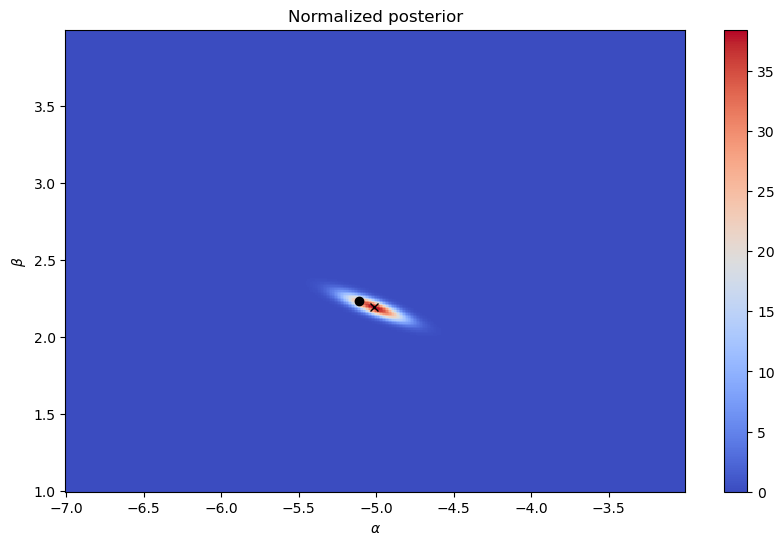

In [225]:
normalizing_factor = np.sum(POST_UNSC) * dalpha * dbeta
POST_SC = POST_UNSC / normalizing_factor


fig, ax = plt.subplots(figsize=(10, 6))
c = ax.pcolormesh(AA, BB, POST_SC, cmap=cm.coolwarm, shading="auto")
plt.plot(theta_map[0], theta_map[1], "kx")
plt.plot(theta_ml[0], theta_ml[1], "ko")
fig.colorbar(c, ax=ax)
ax.set_title(f"Normalized posterior")
ax.set_xlabel(r"$\alpha$")
ax.set_ylabel(r"$\beta$")

* Using the grid-based approximation of the posterior, compute the posterior mean of $\alpha$ and $\beta$.

By definition, we have:

$$E[\theta] = \iint \theta p(\theta | y) d\alpha\; d\beta.$$

Using the grid-based approximation above:

$$E[\theta] = \Delta \alpha \Delta \beta \sum \theta_i p(\theta_i | y).$$

Software implementation below

In [226]:
a_mean = np.sum(AA * POST_SC) * dalpha * dbeta
b_mean = np.sum(BB * POST_SC) * dalpha * dbeta
a_mean, b_mean

(-5.014097287039103, 2.192427911449385)

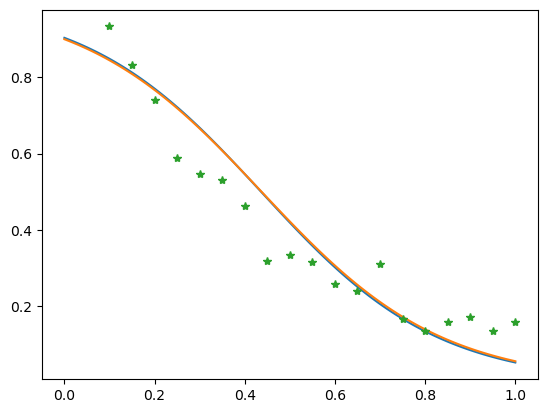

In [227]:
x_range = np.linspace(0, 1, 100)
p_ml = sigmoid(theta_ml[0] * x_range + theta_ml[1])
p_map = sigmoid(theta_map[0] * x_range + theta_map[1])
plt.figure()
plt.plot(x_range, p_ml)
plt.plot(x_range, p_map)
plt.plot(x, prop, "*")

* Obtain a sample-based approximation of the posterior $f(\theta | y)$ using pymc3.

In [263]:
with pm.Model() as golf:
    alpha = pm.Normal("alpha", mu=mu_alpha, sigma=sigma_alpha)
    beta = pm.Normal("beta", mu=mu_beta, sigma=sigma_beta)
    p = pm.Deterministic("p", pm.math.sigmoid(alpha*x + beta))
    y_var = pm.Binomial("y_var", n=n, p=p, observed=y)
    trace = pm.sample(1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Output()

Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 1 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [264]:
with golf:
    display(az.summary(trace))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-5.009,0.132,-5.253,-4.773,0.014,0.010,90.0,134.0,1.04
beta,2.189,0.057,2.085,2.289,0.005,0.004,120.0,148.0,1.02
p[0],0.844,0.006,0.832,0.854,0.001,0.000,135.0,202.0,1.02
p[1],0.808,0.006,0.796,0.819,0.001,0.000,146.0,170.0,1.02
p[2],0.766,0.007,0.753,0.777,0.001,0.000,167.0,214.0,1.01
p[3],0.718,0.007,0.706,0.731,0.000,0.000,202.0,192.0,1.00
p[4],0.665,0.007,0.653,0.680,0.000,0.000,253.0,201.0,1.01
p[5],0.607,0.007,0.594,0.622,0.000,0.000,323.0,233.0,1.01
p[6],0.546,0.008,0.531,0.560,0.000,0.000,388.0,264.0,1.01
p[7],0.484,0.008,0.468,0.497,0.000,0.000,408.0,280.0,1.01


<Axes: >

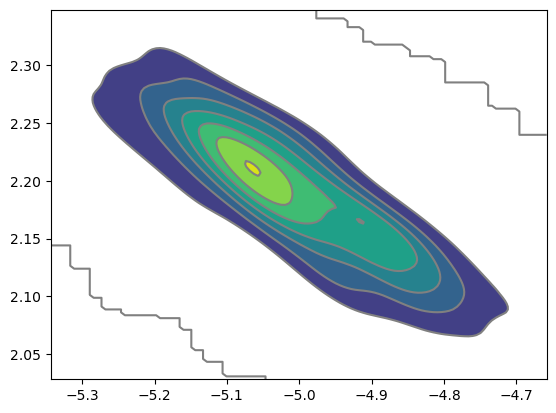

In [265]:
posterior   = az.extract(trace.posterior)
az.plot_kde(posterior.alpha, values2=posterior.beta)

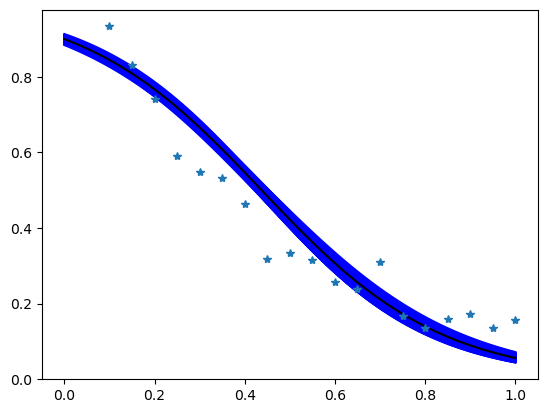

In [270]:
x_range = np.linspace(0, 1, 100)
p_samples = sigmoid(np.expand_dims(posterior.alpha.values, -1) * x_range + np.expand_dims(posterior.beta.values, -1))
plt.figure()
plt.plot(x_range, p_samples[:1000, :].T, "b", alpha=1.0)
plt.plot(x_range, p_map, "k")
plt.plot(x, prop, "*")
#plt.plot(x, prop, "*")